# Samokat.tech Matching

## Описание проекта

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад собираются поступить новые товары, которые могут имеет небольшие различия от уже существующих. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые (предлагаемые для продажи) товары со старыми, пользуясь совпадениями в характеристиках, описаниях и изображениях.

**Что надо сделать?**
- предстоит реализовать финальную часть пайплайна матчинга. В ней необходимо принять решение для каждой пары (товар предлагаемый продавцом — товар на площадке), является ли она матчем или нет (бинарная классификация).
- Для этого у каждой пары есть набор признаков и наборы векторов (картиночные и текстовые), которые описывают товары из этой пары.
- В качестве метрики качества решения используется _F-score_.

**Данные:** [источник](https://www.kaggle.com/competitions/binary-classification-offers-on-the-marketplace/data)

- *train.csv -* обучающий датасет. Содержит пары предложений и товаров, вероятность их мэтча, а так же другие параметры (id товаров, категория и др.)
- *test.csv* - датасет с товарами (уникальный **id** и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *sample_submission.csv* - пример файла предсказаний.

Каждое предложение и товар имеют изображение и название с атрибутами, которые в свою очередь представлены в векторном виде (эмбеддингах).
Embeddings:

- `goods_image_vectors` и `offer_image_vectors` - содержат файлы с векторами изображений (embed_deperson.npy) и их идентификаторами (items_deperson.npy) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1.
- `goods_title_vectors` и `offer_title_vectors` - содержат файлы с векторами названий+атрибутов (embed_deperson.npy) и их идентификаторами (items_deperson.npy) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1.

**План работы:**
- Загрузить данные
- Понять задачу
- Подготовить данные
- Обучить модель
- Измерить качество
- git commit
- Сделать лучше!

Примечание: ячейки кода, исполнение которы занимает продолжительное время, имеют функцию `%%time` и время исполнения, указанное в конце выходных данных. 

___

## Подготовка

In [1]:
# импорт библиотек
import phik
#import faiss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорт спец. модулей
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_curve, ConfusionMatrixDisplay

# константы
FIGSIZE = (14, 6)
RANDOM_STATE = 42
DATA_DIR = 'data/'
ITEMS_FILENAME = 'items_deperson.npy'
EMBEDDINGS_FILENAME = 'embed_deperson.npy'

In [2]:
# чтение датасетов
train_df          = pd.read_csv(DATA_DIR + 'train.csv')
test_df           = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [3]:
# чтение наборов векторов NumPy
goods_image_embed = np.load(DATA_DIR + 'goods_image_vectors/' + EMBEDDINGS_FILENAME)
goods_image_items = np.load(DATA_DIR + 'goods_image_vectors/' + ITEMS_FILENAME)
goods_title_embed = np.load(DATA_DIR + 'goods_title_vectors/' + EMBEDDINGS_FILENAME)
goods_title_items = np.load(DATA_DIR + 'goods_title_vectors/' + ITEMS_FILENAME)

offer_image_embed = np.load(DATA_DIR + 'offer_image_vectors/' + EMBEDDINGS_FILENAME)
offer_image_items = np.load(DATA_DIR + 'offer_image_vectors/' + ITEMS_FILENAME)
offer_title_embed = np.load(DATA_DIR + 'offer_title_vectors/' + EMBEDDINGS_FILENAME)
offer_title_items = np.load(DATA_DIR + 'offer_title_vectors/' + ITEMS_FILENAME)

При первичном знакомстве с данными обнаружил опечатку в названиях пары столбцов. Дабы не множить её, я внесу исправление в самом начале. 

`offer_depersAnalised` -> `offer_depersOnalised`

`goods_depersAnalised` -> `goods_depersOnalised`

In [4]:
# коррекция опечатки
for df in (train_df, test_df):
    df.rename(columns={'offer_depersanalised' : 'offer_depersonalised',
                       'goods_depersanalised' : 'goods_depersonalised'}, inplace=True)
    print('Обновлённые названия:', list(df.columns[0:2]))

Обновлённые названия: ['offer_depersonalised', 'goods_depersonalised']
Обновлённые названия: ['offer_depersonalised', 'goods_depersonalised']


___

## Первичный анализ данных

Описание колонок:

- `offer_depersonalised` и `goods_depersonalised` - идентификаторы предложения и товара соответственно
- `sum_length` - суммарная длина пары названий и атрибутов в символах
- `dist` - расстояние между названиями предложения и товара*
- `attrs+title_score` - вероятность матча от рескоринговой модели
- `offer_price` и `goods_price` - цена предложения и товара соответственно
- `goods_category_id` - категория товара
- `id` - идентификатор пары offer_depersonalised + $ + goods_depersonalised
- `target` (только в train.csv) - метка класса (0 - не матч, 1 - матч)

\* столбец заявлен, но отсутствует в исходных данных.

### Train

In [5]:
# вывод общей информации
display(train_df.head())
train_df.info(verbose=True, show_counts=True)

print('Кол-во мэтчей-дубликатов:', train_df.duplicated().sum())
print('Кол-во предложений:', len(train_df['offer_depersonalised'].unique()))
print('Кол-во товаров:', len(train_df['goods_depersonalised'].unique()))

# выделение цел. признака из обучающей выборки
#train_targets = train_df['target']
#train_df.drop('target', axis=1, inplace=True)

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   offer_depersonalised  2518441 non-null  int64  
 1   goods_depersonalised  2518441 non-null  int64  
 2   sum_length            2518441 non-null  int64  
 3   attrs+title_score     2518441 non-null  float64
 4   offer_price           2518441 non-null  int64  
 5   goods_price           2111154 non-null  float64
 6   goods_category_id     2517608 non-null  float64
 7   target                2518441 non-null  int64  
 8   id                    2518441 non-null  object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB
Кол-во мэтчей-дубликатов: 0
Кол-во предложений: 500000
Кол-во товаров: 1592607


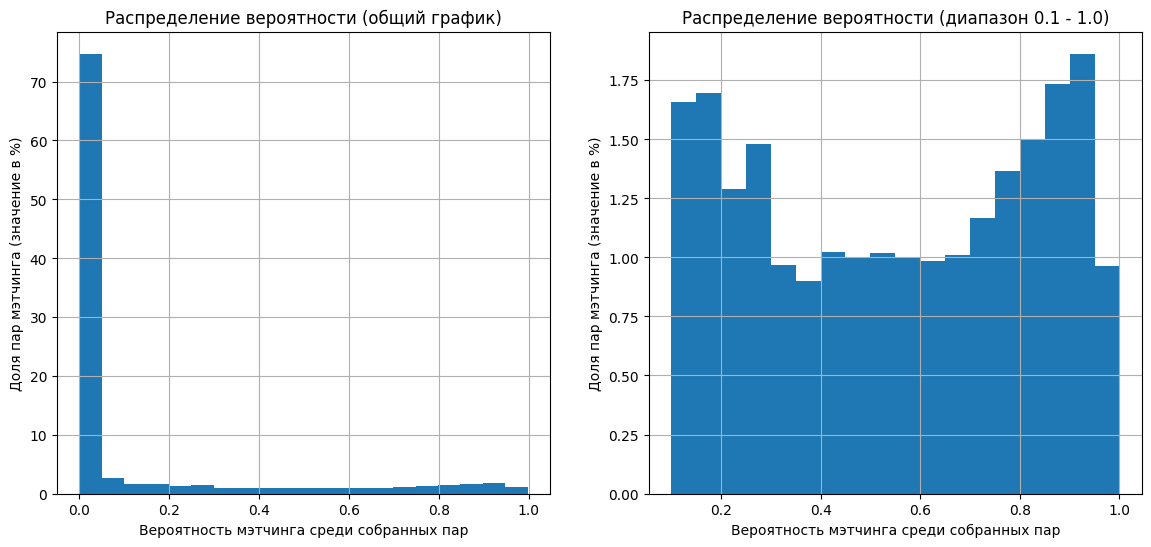

In [6]:
# вероятность матчинга
fig, axs = plt.subplots(1, 2, figsize=FIGSIZE)

axs[0].hist(train_df['attrs+title_score'], bins=20, weights=np.ones(len(train_df))/len(train_df)*100)
axs[0].set_title('Распределение вероятности (общий график)')
axs[0].set_ylabel('Доля пар мэтчинга (значение в %)')
axs[0].set_xlabel('Вероятность мэтчинга среди собранных пар')
axs[0].grid()

axs[1].hist(train_df['attrs+title_score'], bins=18, weights=np.ones(len(train_df))/len(train_df)*100, range=(0.1, 1.0))
axs[1].set_title('Распределение вероятности (диапазон 0.1 - 1.0)')
axs[1].set_ylabel('Доля пар мэтчинга (значение в %)')
axs[1].set_xlabel('Вероятность мэтчинга среди собранных пар')
axs[1].grid()
plt.show()

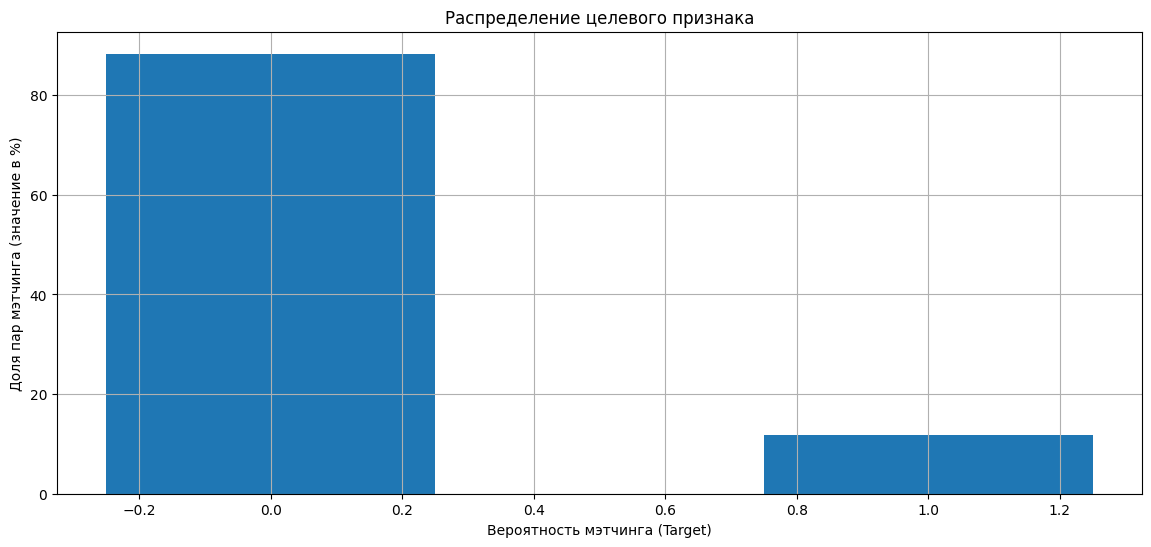

In [7]:
# целевой признак
train_df['target'].hist(figsize=FIGSIZE, weights=np.ones(len(train_df))/len(train_df)*100, bins=3, range=(-0.25, 1.25))
plt.title('Распределение целевого признака')
plt.ylabel('Доля пар мэтчинга (значение в %)')
plt.xlabel('Вероятность мэтчинга (Target)')
plt.show()

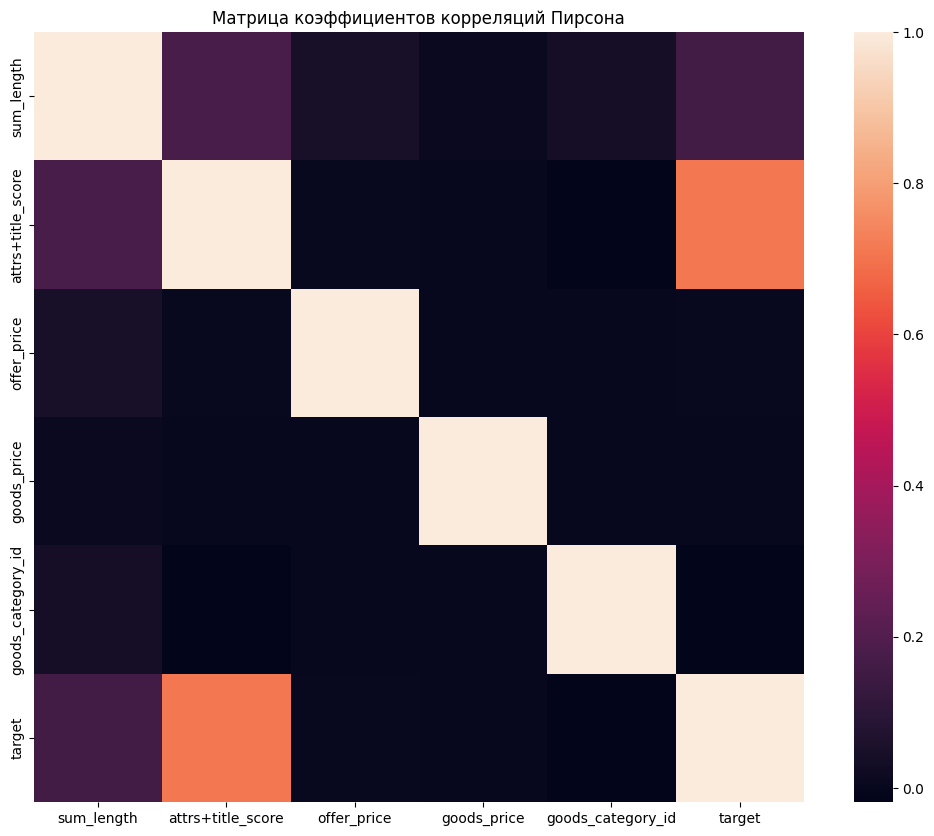

In [8]:
# корреляция Пирсона
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(train_df.loc[:, 'sum_length':'target'].corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона');

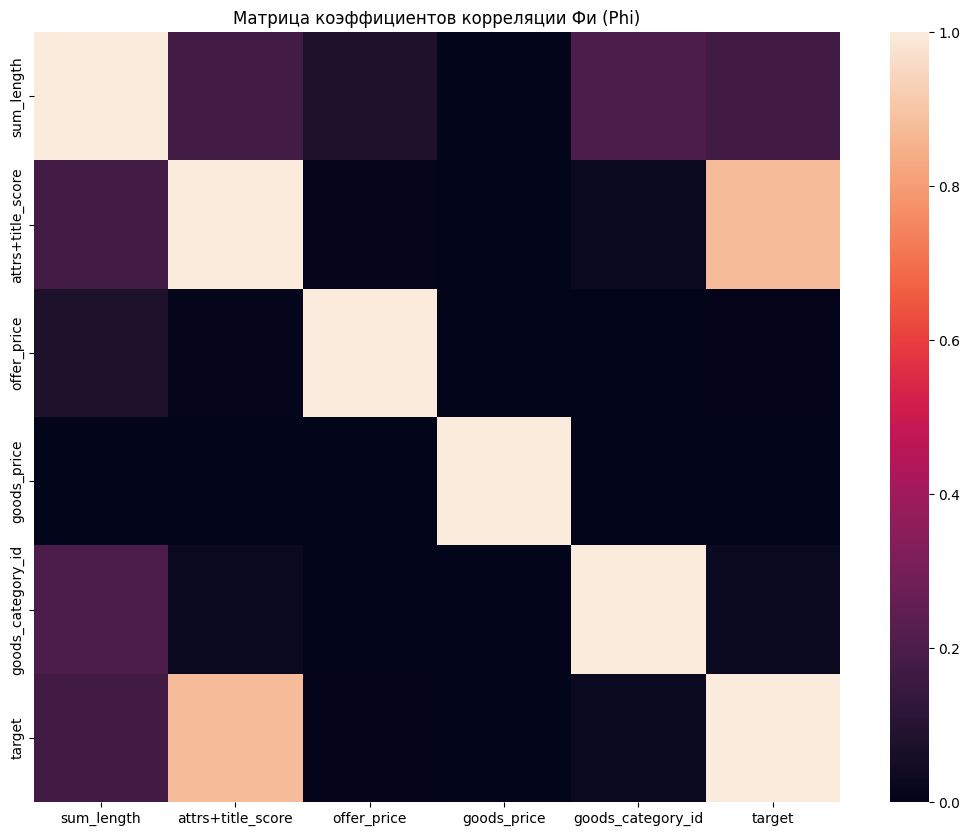

In [9]:
# корреляции Фи
num_columns = ['sum_length', 'attrs+title_score', 'offer_price', 'goods_price', 'goods_category_id', 'target']
phik_matrix = train_df[num_columns].phik_matrix(interval_cols=num_columns)
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(phik_matrix)
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

In [10]:
# категории товаров
#train_df['goods_category_id'] = train_df['goods_category_id'].astype('Int64')
print('ID категорий:', sorted(list(train_df['goods_category_id'].unique())))
print('Кол-во категорий:', len(train_df['goods_category_id'].unique()))
display(train_df['goods_category_id'].value_counts().to_frame())#.sort_index().head(-1)#.hist(bins=20)

ID категорий: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 13.0, 14.0, 17.0, 18.0, 19.0, 21.0, 69.0, 81.0, 82.0, 83.0, 2463684633817211.0, nan]
Кол-во категорий: 21


,count
goods_category_id,
5.000000e+00,460420
6.000000e+00,312857
2.000000e+00,249113
3.000000e+00,195435
1.400000e+01,154753
8.000000e+00,153579
7.000000e+00,150662
8.300000e+01,142425
1.100000e+01,104619


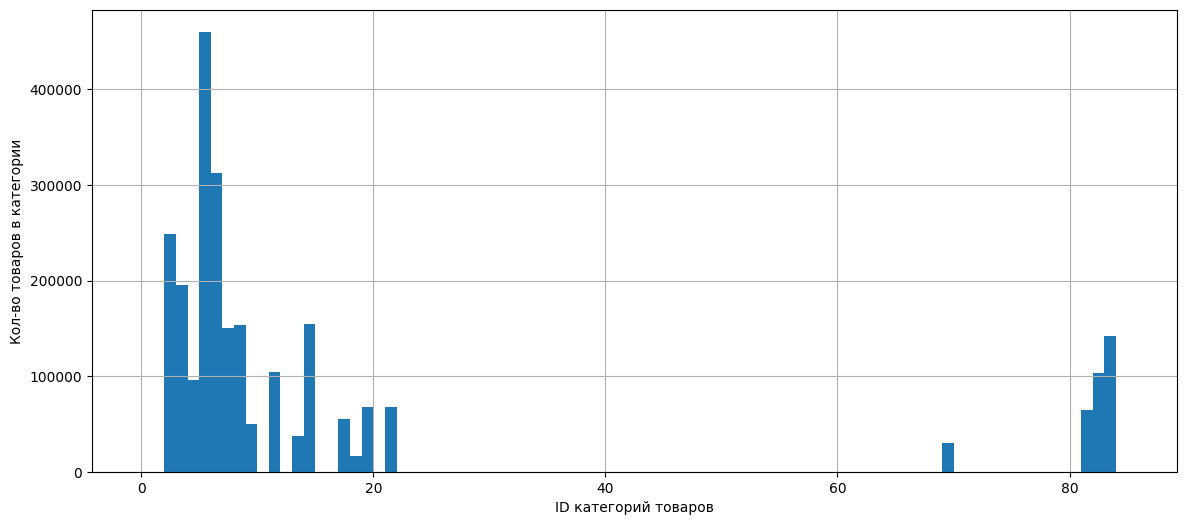

In [11]:
train_df['goods_category_id'].hist(bins=85, range=(0, 85), figsize=FIGSIZE)
plt.ylabel('Кол-во товаров в категории')
plt.xlabel('ID категорий товаров')
plt.show()

Промежуточный вывод:

- Всего около 2,5 млн пар для мэтча.
- Приблизительно на 75% пар для мэтчинга приходится нулевая вероятность. А с учётом колонки `target` 85% пар - несовместимы, лишь 15% пар соотносятся друг с другом. Классы имеют сильный дисбаланс.
- Существует явно выраженная линейная зависимость между `attrs+title_score` и `target`
- Пропуски присутствуют лишь в столбцах `goods_price` и `goods_category_id`.
- Категорий товаров - небольшое количество. Все они обозначены условными номерами. Поскольку это целые числа, то тип данных уместно заменить на `Int64`. В дополнение он поддерживает nan-значения. Особый интерес вызывает категория №2463684633817211. Номер особо выделяется на фоне остальных. Это самая малочисленная категория, но тем не менее она содержит почти 5000 товаров.

### Test

In [12]:
# вывод общей информации
display(test_df.head())
test_df.info(verbose=True, show_counts=True)

print('Кол-во мэтчей-дубликатов:', test_df.duplicated().sum())
print('Кол-во предложений:', len(test_df['offer_depersonalised'].unique()))
print('Кол-во товаров:', len(test_df['goods_depersonalised'].unique()))

,offer_depersonalised,goods_depersonalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,38,0.046997,368,NaN,14.0,64819$1396468
1,64819,1396235,38,0.046997,368,NaN,14.0,64819$1396235
2,64819,1396318,38,0.046997,368,NaN,14.0,64819$1396318
3,359959,1396281,40,0.060211,634,NaN,14.0,359959$1396281
4,142700,717657,40,0.000370,14924,31840.0,2.0,142700$717657


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersonalised  363835 non-null  int64  
 1   goods_depersonalised  363835 non-null  int64  
 2   sum_length            363835 non-null  int64  
 3   attrs+title_score     363835 non-null  float64
 4   offer_price           363835 non-null  int64  
 5   goods_price           304864 non-null  float64
 6   goods_category_id     363704 non-null  float64
 7   id                    363835 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 22.2+ MB
Кол-во мэтчей-дубликатов: 0
Кол-во предложений: 72767
Кол-во товаров: 316987


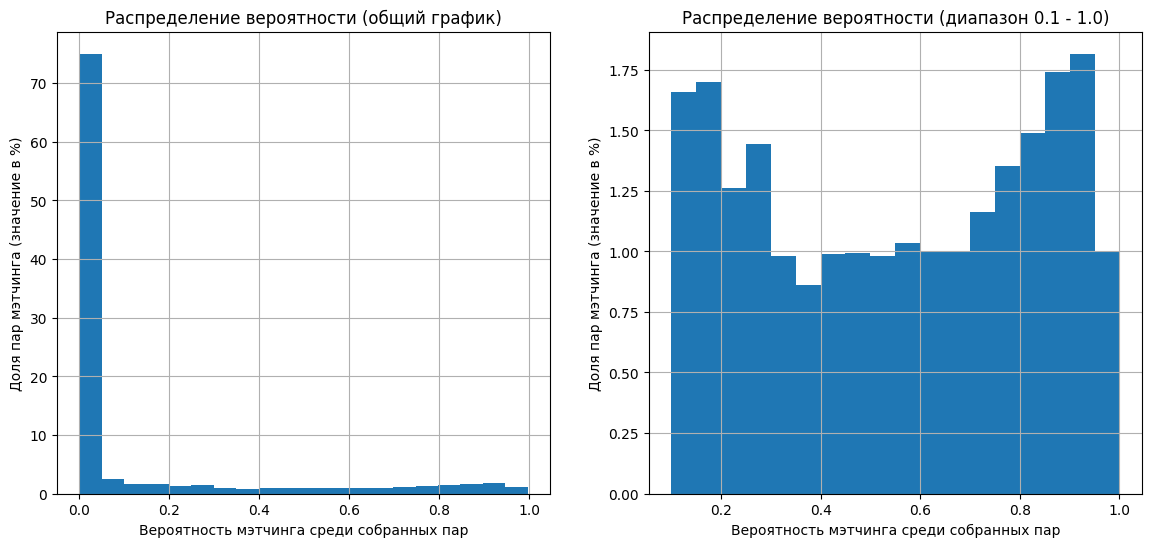

In [13]:
# вероятность матчинга
fig, axs = plt.subplots(1, 2, figsize=FIGSIZE)

axs[0].hist(test_df['attrs+title_score'], bins=20, weights=np.ones(len(test_df))/len(test_df)*100)
axs[0].set_title('Распределение вероятности (общий график)')
axs[0].set_ylabel('Доля пар мэтчинга (значение в %)')
axs[0].set_xlabel('Вероятность мэтчинга среди собранных пар')
axs[0].grid()

axs[1].hist(test_df['attrs+title_score'], bins=18, weights=np.ones(len(test_df))/len(test_df)*100, range=(0.1, 1.0))
axs[1].set_title('Распределение вероятности (диапазон 0.1 - 1.0)')
axs[1].set_ylabel('Доля пар мэтчинга (значение в %)')
axs[1].set_xlabel('Вероятность мэтчинга среди собранных пар')
axs[1].grid()
plt.show()

In [14]:
# категории товаров
print('ID категорий:', sorted(list(test_df['goods_category_id'].unique())))
print('Кол-во категорий:', len(test_df['goods_category_id'].unique()))
display(test_df['goods_category_id'].value_counts().to_frame())

ID категорий: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 13.0, 14.0, 17.0, 18.0, 19.0, 21.0, 69.0, 81.0, 82.0, 83.0, 2463684633817211.0, nan]
Кол-во категорий: 21


,count
goods_category_id,
5.000000e+00,66720
6.000000e+00,45782
2.000000e+00,36526
3.000000e+00,28179
1.400000e+01,22839
8.000000e+00,22193
7.000000e+00,21705
8.300000e+01,20364
1.100000e+01,15450


Промежуточный вывод:

- Всего около 363 тыс. пар для мэтча.
- Если ориентироваться на распределение вероятности в колонке `attrs+title_score`, то соотношение классов в тренировочной и тестовой выборках идентичны.
- Пропуски присутствуют в тех же столбцах: `goods_price` и `goods_category_id`.
- Количество категорий товаров - то же количество: 21. И тот же перечень, что и в `train_df`. В том же виде сохранилось распределение товаров по этим категориям.


### Набор данных **товаров** (goods image & title)

Напомню, что датасет содержит в первую очередь id товаров и предложений. А данные, которые могут их охарактеризовать содержатся в отдельных маборах данных формата `.npy`.

Пример содержания массива эмбеддингов:
 [[ 1.1158133   1.9842914   0.5167014  ... -0.69889563  0.11544477
  -3.1679373 ]
 [ 0.99327075  1.9756604   0.23954017 ...  0.00989665  0.49230903
  -3.0051124 ]
 [-0.36902365 -2.316401    1.3042173  ... -1.6195703   0.7884472
  -2.6850224 ]
 ...
 [-0.16678151 -0.6597981  -0.9382939  ...  0.3883793  -0.21414155
   0.41041985]
 [-0.16678151 -0.6597981  -0.9382939  ...  0.3883793  -0.21414155
   0.41041985]
 [-0.16678151 -0.6597981  -0.9382939  ...  0.3883793  -0.21414155
   0.41041985]]
Размер массива: (317707, 256)
Макс. значение массива: 9.318618
Мин. значение массива: -10.725204


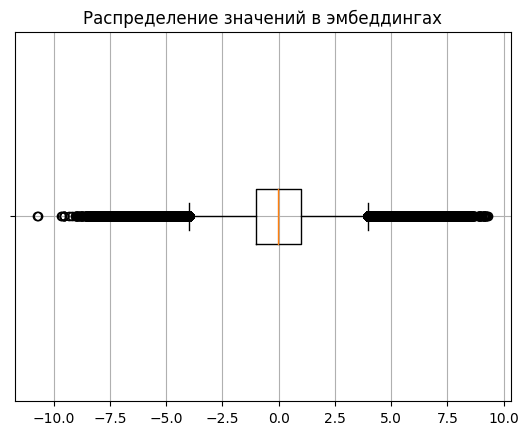

In [15]:
# эмбеддинги изображений товаров
print('Пример содержания массива эмбеддингов:\n', goods_image_embed)
print('Размер массива:', goods_image_embed.shape)

max_value = max(max(row) for row in goods_image_embed)
min_value = min(min(row) for row in goods_image_embed)
print('Макс. значение массива:', max_value)
print('Мин. значение массива:', min_value)

plt.boxplot(goods_image_embed.flatten(), vert=False, labels=[''])
plt.title('Распределение значений в эмбеддингах')
plt.grid(True)
plt.show()

In [16]:
# массив id изображений товаров
display(goods_image_items)
print('Размер массива:', goods_image_items.shape)

array(['37', '39', '49', ..., '1749527', '1749528', '1749541'],
      dtype='<U7')

Размер массива: (317707,)


Пример содержания массива эмбеддингов:
 [[-0.1097    -0.03256   -0.1995    ...  0.0008154  0.01423   -0.0924   ]
 [ 0.05478    0.0456     0.086     ...  0.04526   -0.0991     0.0728   ]
 [ 0.1026    -0.05792   -0.01443   ...  0.02373    0.1375     0.03757  ]
 ...
 [-0.1048     0.02689    0.05493   ... -0.02917    0.1359    -0.02756  ]
 [ 0.03458    0.12256    0.08636   ...  0.02022   -0.01162   -0.11     ]
 [ 0.09845    0.099     -0.0207    ...  0.03278    0.0746    -0.04443  ]]
Размер массива: (1760568, 64)
Макс. значение массива: 0.3892
Мин. значение массива: -0.4036


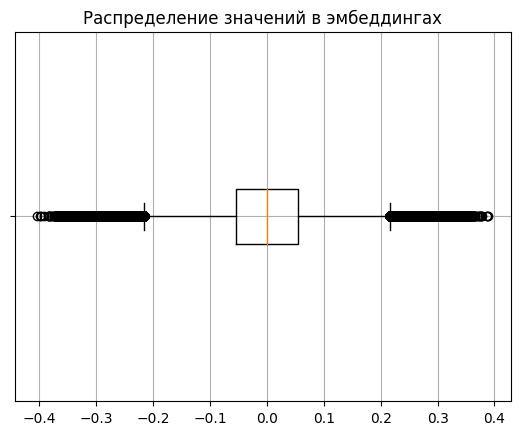

CPU times: total: 18.3 s
Wall time: 18.4 s


In [17]:
%%time
# эмбеддинги названий и атрибутов товаров
print('Пример содержания массива эмбеддингов:\n', goods_title_embed)
print('Размер массива:', goods_title_embed.shape)

print('Макс. значение массива:', max(max(row) for row in goods_title_embed))
print('Мин. значение массива:', min(min(row) for row in goods_title_embed))

plt.boxplot(goods_title_embed.flatten(), vert=False, labels=[''])
plt.title('Распределение значений в эмбеддингах')
plt.grid(True)
plt.show()

In [18]:
# массив id названий и атрибутов товаров
display(goods_title_items)
print('Размер массива:', goods_title_items.shape)

array(['0', '1', '2', ..., '1760565', '1760566', '1760567'], dtype='<U7')

Размер массива: (1760568,)


Промежуточный вывод:

- 317 тыс. векторизованных изображений. Длинна вектора: 256
- Судя по графику распределения значений, большинство векторов изображений отмасштабированы.
- 1,7 млн. векторизованных названий с атрибутами. Длинна вектора: 64
- аналогичное нормальное распределение значений наблюдается и у векторов текстовой информации
- количество векторов совпадает с количеством items

### Набор данных **предложений** (offer image & title)

Такой же ознакомительный анализ проведу для предложенных товаров.

Пример содержания массива:
 [[ 0.31286708  0.9922713   1.2100751  ... -1.7545763  -0.23919716
  -1.2425919 ]
 [ 2.4316337   0.9014603  -0.22259077 ... -1.1001699  -1.1482008
  -0.18731171]
 [ 1.0660228  -0.752132    1.1504172  ...  0.9137148  -0.8000038
  -0.83978504]
 ...
 [ 0.15886657  1.1132201   1.8915755  ... -1.9614205   0.25737146
   2.2726674 ]
 [-0.07633805  1.1760142   1.7563714  ...  0.8059396  -0.01547651
  -1.1802496 ]
 [ 2.2704175  -0.9822532  -0.21690361 ...  1.8719108  -0.7007608
  -1.5808858 ]]
Размер массива: (457586, 256)
Макс. значение массива: 10.499202
Мин. значение массива: -10.556353


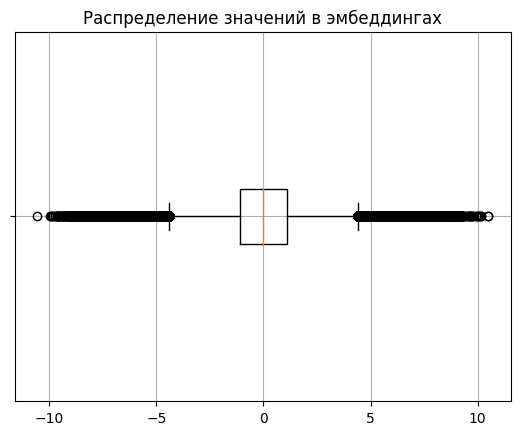

In [19]:
# эмбеддинги изображений предложений
print('Пример содержания массива:\n', offer_image_embed)
print('Размер массива:', offer_image_embed.shape)

print('Макс. значение массива:', max(max(row) for row in offer_image_embed))
print('Мин. значение массива:', min(min(row) for row in offer_image_embed))

plt.boxplot(offer_image_embed.flatten(), vert=False, labels=[''])
plt.title('Распределение значений в эмбеддингах')
plt.grid(True)
plt.show()

In [20]:
# массив id предложений
display(offer_image_items)
print('Размер массива:', offer_image_items.shape)

array(['140', '185', '187', ..., '572691', '572699', '572735'],
      dtype='<U6')

Размер массива: (457586,)


Пример содержания массива эмбеддингов:
 [[ 0.1005    0.01372   0.02437  ... -0.0833   -0.07996   0.01242 ]
 [-0.0225   -0.2683   -0.06757  ... -0.07855  -0.1098   -0.1461  ]
 [-0.129    -0.0601    0.132    ...  0.0827   -0.01355  -0.1091  ]
 ...
 [ 0.03424   0.1057   -0.1775   ...  0.00539  -0.07495  -0.05234 ]
 [ 0.1133   -0.0424   -0.01152  ...  0.07196  -0.08386  -0.04617 ]
 [ 0.02773   0.012505 -0.02528  ...  0.04718  -0.0552   -0.04034 ]]
Размер массива: (572767, 64)
Макс. значение массива: 0.3806
Мин. значение массива: -0.3906


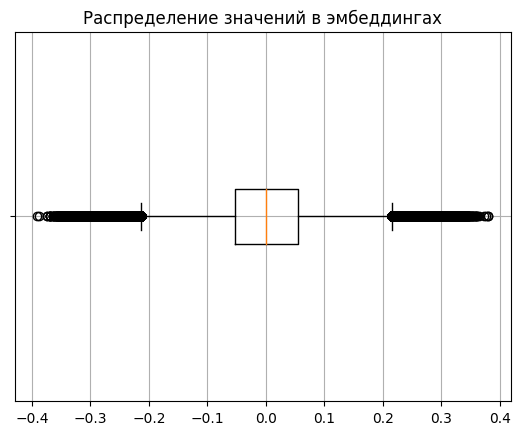

In [21]:
# эмбеддинги названий и атрибутов предложений
print('Пример содержания массива эмбеддингов:\n', offer_title_embed)
print('Размер массива:', offer_title_embed.shape)

print('Макс. значение массива:', max(max(row) for row in offer_title_embed))
print('Мин. значение массива:', min(min(row) for row in offer_title_embed))

plt.boxplot(offer_title_embed.flatten(), vert=False, labels=[''])
plt.title('Распределение значений в эмбеддингах')
plt.grid(True)
plt.show()

In [22]:
# массив id названий и атрибутов предложений
display(offer_title_items)
print('Размер массива:', offer_title_items.shape)

array(['477447', '95232', '117886', ..., '30926', '209577', '239103'],
      dtype='<U6')

Размер массива: (572767,)


Промежуточный вывод:

- 457 тыс. векторизованных изображений. Длинна вектора такая же: 256
- Масштаб значений векторов - аналогичен набору товаров.
- 572 тыс. векторизованных названий с атрибутами. Длинна вектора такая же: 64
- Масштаб значений векторов - такой же
- количество векторов совпадает с количеством items

Общий вывод по первичному анализу:

- Обучающий и тестовый датасеты содержат данные в схожем виде. Соотношение между классами, вероятно всего, одинаковое. 
- Присутствует небольшое кол-во пропусков `goods_price` и `goods_category_id`.
- Наборы текстовых и картиночных данных отличаются количеством объектов, но размеры векторов, а так же их масштаб - совпадают.

___